## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 30 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]


reduce_lr_factor = [0.25, 0.5]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor='val_loss', 
                                  patience=reduce_patient,
                                  verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 6s 114us/step - loss: 1.6210 - acc: 0.4357 - val_loss: 1.7071 - val_acc: 0.4035
Epoch 9/30
50000/50000 [==============================] - 4s 76us/step - loss: 1.5935 - acc: 0.4453 - val_loss: 1.6807 - val_acc: 0.4110
Epoch 10/30
50000/50000 [==============================] - 4s 77us/step - loss: 1.5691 - acc: 0.4535 - val_loss: 1.6676 - val_acc: 0.4188
Epoch 11/30
50000/50000 [==============================] - 4s 81us/step - loss: 1.5478 - acc: 0.4605 - val_loss: 1.6517 - val_acc: 0.4213
Epoch 12/30
50000/50000 [==============================] - 5s 103us/step - loss: 1.5286 - acc: 0.4690 - val_loss: 1.6399 - val_acc: 0.4248
Epoch 13/30
50000/50000 [==============================] - 4s 90us/step - loss: 1.5097 - acc: 0.4731 - val_loss: 1.6310 - val_acc: 0.4269
Epoch 14/30
50000/50000 [==============================] - 4s 80us/step - loss: 1.4920 - acc: 0.4806 - val_loss: 1.6160 - val_acc: 0.4348
Epoch 15/30
50000/50000 [====================

50000/50000 [==============================] - 3s 65us/step - loss: 1.3206 - acc: 0.5426 - val_loss: 1.5409 - val_acc: 0.4604
Epoch 27/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3105 - acc: 0.5454 - val_loss: 1.5362 - val_acc: 0.4607
Epoch 28/30
50000/50000 [==============================] - 3s 64us/step - loss: 1.3004 - acc: 0.5501 - val_loss: 1.5317 - val_acc: 0.4611
Epoch 29/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.2902 - acc: 0.5551 - val_loss: 1.5258 - val_acc: 0.4658
Epoch 30/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.2805 - acc: 0.5565 - val_loss: 1.5265 - val_acc: 0.4665
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________


50000/50000 [==============================] - 4s 71us/step - loss: 1.8679 - acc: 0.3516 - val_loss: 1.9065 - val_acc: 0.3496
Epoch 4/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.7823 - acc: 0.3771 - val_loss: 1.8340 - val_acc: 0.3696
Epoch 5/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.7236 - acc: 0.3975 - val_loss: 1.7915 - val_acc: 0.3794
Epoch 6/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.6768 - acc: 0.4121 - val_loss: 1.7488 - val_acc: 0.3899
Epoch 7/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.6405 - acc: 0.4250 - val_loss: 1.7195 - val_acc: 0.3989
Epoch 8/30
50000/50000 [==============================] - 3s 64us/step - loss: 1.6092 - acc: 0.4359 - val_loss: 1.7012 - val_acc: 0.4059
Epoch 9/30
50000/50000 [==============================] - 3s 64us/step - loss: 1.5833 - acc: 0.4464 - val_loss: 1.6757 - val_acc: 0.4125
Epoch 10/30
50000/50000 [===========================

50000/50000 [==============================] - 4s 79us/step - loss: 1.3720 - acc: 0.5252 - val_loss: 1.5670 - val_acc: 0.4516
Epoch 22/30
50000/50000 [==============================] - 4s 83us/step - loss: 1.3596 - acc: 0.5284 - val_loss: 1.5636 - val_acc: 0.4489
Epoch 23/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.3482 - acc: 0.5332 - val_loss: 1.5557 - val_acc: 0.4532
Epoch 24/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3377 - acc: 0.5367 - val_loss: 1.5509 - val_acc: 0.4537
Epoch 25/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.3264 - acc: 0.5404 - val_loss: 1.5478 - val_acc: 0.4554
Epoch 26/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.3148 - acc: 0.5444 - val_loss: 1.5452 - val_acc: 0.4601
Epoch 27/30
50000/50000 [==============================] - 3s 69us/step - loss: 1.3050 - acc: 0.5475 - val_loss: 1.5362 - val_acc: 0.4574
Epoch 28/30
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 7s 142us/step - loss: 2.4138 - acc: 0.2156 - val_loss: 2.2323 - val_acc: 0.2748
Epoch 2/30
50000/50000 [==============================] - 4s 80us/step - loss: 2.0107 - acc: 0.3149 - val_loss: 2.0331 - val_acc: 0.3185
Epoch 3/30
50000/50000 [==============================] - 4s 72us/step - loss: 1.9021 - acc: 0.3454 - val_loss: 1.9539 - val_acc: 0.3324
Epoch 4/30
50000/50000 [==============================] - 4s 89us/step - loss: 1.8402 - acc: 0.3645 - val_loss: 1.8892 - val_acc: 0.3527
Epoch 5/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.7966 - acc: 0.3808 - val_loss: 1.8537 - val_acc: 0.3641
Epoch 6/30
50000/50000 [==============================] - 4s 74us/step - loss: 1.7621 - acc: 0.3903 - val_loss: 1.8273 - val_acc: 0.3736
Epoch 7/30
50000/50000 [==============================] - 4s 83us/step - loss: 1.7337 - acc: 0.4010 - val_loss: 1.8037 - val_ac

50000/50000 [==============================] - 3s 66us/step - loss: 1.5368 - acc: 0.4615 - val_loss: 1.6601 - val_acc: 0.4143
Epoch 20/30
50000/50000 [==============================] - 3s 70us/step - loss: 1.5277 - acc: 0.4652 - val_loss: 1.6556 - val_acc: 0.4203
Epoch 21/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.5182 - acc: 0.4671 - val_loss: 1.6498 - val_acc: 0.4220
Epoch 22/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.5119 - acc: 0.4703 - val_loss: 1.6471 - val_acc: 0.4214
Epoch 23/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.5034 - acc: 0.4746 - val_loss: 1.6407 - val_acc: 0.4235
Epoch 24/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.4955 - acc: 0.4773 - val_loss: 1.6361 - val_acc: 0.4254
Epoch 25/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.4883 - acc: 0.4781 - val_loss: 1.6332 - val_acc: 0.4243
Epoch 26/30
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 7s 143us/step - loss: 2.4371 - acc: 0.2196 - val_loss: 2.2501 - val_acc: 0.2776 5s - 
Epoch 2/30
50000/50000 [==============================] - 3s 67us/step - loss: 2.0285 - acc: 0.3147 - val_loss: 2.0547 - val_acc: 0.31754 - ac
Epoch 3/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.9146 - acc: 0.3448 - val_loss: 1.9584 - val_acc: 0.3395
Epoch 4/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.8462 - acc: 0.3647 - val_loss: 1.8988 - val_acc: 0.3517
Epoch 5/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.7989 - acc: 0.3778 - val_loss: 1.8569 - val_acc: 0.3607
Epoch 6/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.7614 - acc: 0.3887 - val_loss: 1.8268 - val_acc: 0.3719
Epoch 7/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.7326 - acc: 0.3985 - val_loss: 1.8

Epoch 19/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.5483 - acc: 0.4634 - val_loss: 1.6744 - val_acc: 0.4185
Epoch 20/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.5400 - acc: 0.4678 - val_loss: 1.6672 - val_acc: 0.4217
Epoch 21/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.5309 - acc: 0.4699 - val_loss: 1.6621 - val_acc: 0.4239
Epoch 22/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.5222 - acc: 0.4738 - val_loss: 1.6574 - val_acc: 0.4274
Epoch 23/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.5142 - acc: 0.4768 - val_loss: 1.6540 - val_acc: 0.4293
Epoch 24/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.5069 - acc: 0.4797 - val_loss: 1.6474 - val_acc: 0.4317
Epoch 25/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.4994 - acc: 0.4819 - val_loss: 1.6447 - val_acc: 0.4322
Epoch 26/30
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 165us/step - loss: 2.3414 - acc: 0.2269 - val_loss: 2.1604 - val_acc: 0.2863
Epoch 2/30
50000/50000 [==============================] - 4s 73us/step - loss: 2.0019 - acc: 0.3141 - val_loss: 1.9795 - val_acc: 0.3304
Epoch 3/30
50000/50000 [==============================] - 4s 72us/step - loss: 1.8620 - acc: 0.3545 - val_loss: 1.8927 - val_acc: 0.3578
Epoch 4/30
50000/50000 [==============================] - 4s 72us/step - loss: 1.7717 - acc: 0.3830 - val_loss: 1.8281 - val_acc: 0.3726
Epoch 5/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.7075 - acc: 0.4031 - val_loss: 1.7780 - val_acc: 0.3887
Epoch 6/30
50000/50000 [==============================] - 3s 70us/step - loss: 1.6566 - acc: 0.4200 - val_loss: 1.7463 - val_acc: 0.4024
Epoch 7/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.6144 - acc: 0.4334 - val_loss: 1.7112 - val_ac

Epoch 19/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3741 - acc: 0.5255 - val_loss: 1.6073 - val_acc: 0.4432
Epoch 20/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3591 - acc: 0.5294 - val_loss: 1.5935 - val_acc: 0.4486
Epoch 21/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.3445 - acc: 0.5364 - val_loss: 1.5865 - val_acc: 0.4493
Epoch 22/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3317 - acc: 0.5408 - val_loss: 1.5870 - val_acc: 0.4507
Epoch 23/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3178 - acc: 0.5472 - val_loss: 1.5724 - val_acc: 0.4551
Epoch 24/30
50000/50000 [==============================] - 3s 65us/step - loss: 1.3042 - acc: 0.5518 - val_loss: 1.5718 - val_acc: 0.4568
Epoch 25/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.2906 - acc: 0.5573 - val_loss: 1.5634 - val_acc: 0.4561
Epoch 26/30
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 151us/step - loss: 2.3922 - acc: 0.2186 - val_loss: 2.2217 - val_acc: 0.2725
Epoch 2/30
50000/50000 [==============================] - 3s 66us/step - loss: 2.0307 - acc: 0.3063 - val_loss: 2.0593 - val_acc: 0.3145
Epoch 3/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.8835 - acc: 0.3483 - val_loss: 1.9462 - val_acc: 0.3341
Epoch 4/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.7952 - acc: 0.3773 - val_loss: 1.8631 - val_acc: 0.3606
Epoch 5/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.7305 - acc: 0.3978 - val_loss: 1.7989 - val_acc: 0.3766
Epoch 6/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.6792 - acc: 0.4152 - val_loss: 1.7727 - val_acc: 0.3846
Epoch 7/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.6374 - acc: 0.4290 - val_loss: 1.7338 - val_ac

50000/50000 [==============================] - 3s 66us/step - loss: 1.3669 - acc: 0.5289 - val_loss: 1.5857 - val_acc: 0.4453
Epoch 20/30
50000/50000 [==============================] - 3s 68us/step - loss: 1.3521 - acc: 0.5346 - val_loss: 1.5810 - val_acc: 0.4499
Epoch 21/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3368 - acc: 0.5395 - val_loss: 1.5710 - val_acc: 0.4498
Epoch 22/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3233 - acc: 0.5450 - val_loss: 1.5667 - val_acc: 0.4542
Epoch 23/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.3097 - acc: 0.5508 - val_loss: 1.5641 - val_acc: 0.4554
Epoch 24/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.2976 - acc: 0.5551 - val_loss: 1.5562 - val_acc: 0.4570
Epoch 25/30
50000/50000 [==============================] - 3s 66us/step - loss: 1.2837 - acc: 0.5609 - val_loss: 1.5558 - val_acc: 0.4582
Epoch 26/30
50000/50000 [=====================

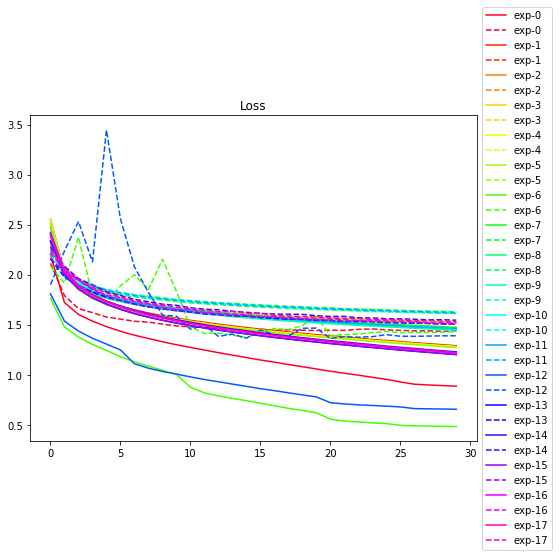

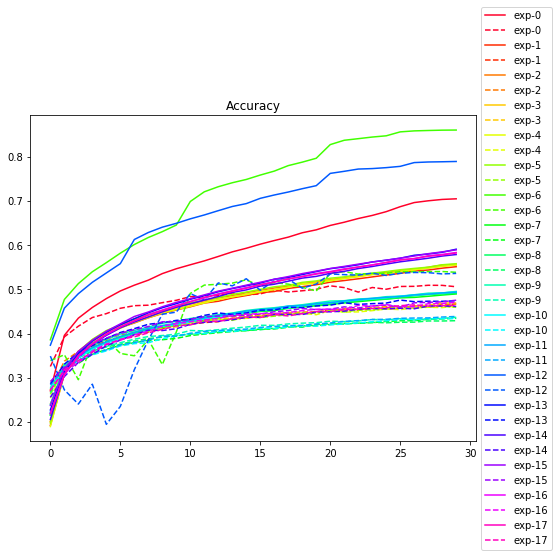

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()